# Contradictory Watson

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
import os
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [19]:
for dirname, _, filenames in os.walk('./../../project_watson/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./../../project_watson/data/test.csv
./../../project_watson/data/train.csv
./../../project_watson/data/sample_submission.csv


In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Downloading data

In [20]:
train = pd.read_csv("./../../project_watson/data/train.csv")

In [21]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [22]:
train.premise[2]

"Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire."

In [23]:
train.premise.values[0]

'and these comments were considered in formulating the interim rules.'

In [24]:
np.unique(train.hypothesis.values, return_counts = True)

(array([' "The Man Nobody Knows," by Bruce Barton, was never a best seller.',
        " Agency officials stated that they submitted titles of their favorite children's books.",
        ' And environmentalists have on occasion attacked religion.', ...,
        '阿拉贝拉刚好位于穿过港口边缘的地方，那是城市其余部分的位置所在。', '陪审团总是13人。', '香农对这条信息进行了计算分析。'],
       dtype=object),
 array([1, 1, 1, ..., 1, 1, 1]))

In [25]:
labels, frequencies = np.unique(train.language.values, return_counts = True)
labels

array(['Arabic', 'Bulgarian', 'Chinese', 'English', 'French', 'German',
       'Greek', 'Hindi', 'Russian', 'Spanish', 'Swahili', 'Thai',
       'Turkish', 'Urdu', 'Vietnamese'], dtype=object)

In [26]:
explode = []
for i in range(len(labels)):
    if labels[i] == 'English':
        explode.append(0.1)
    else:
        explode.append(0.2)
explode = tuple(explode)

In [27]:
explode

(0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)

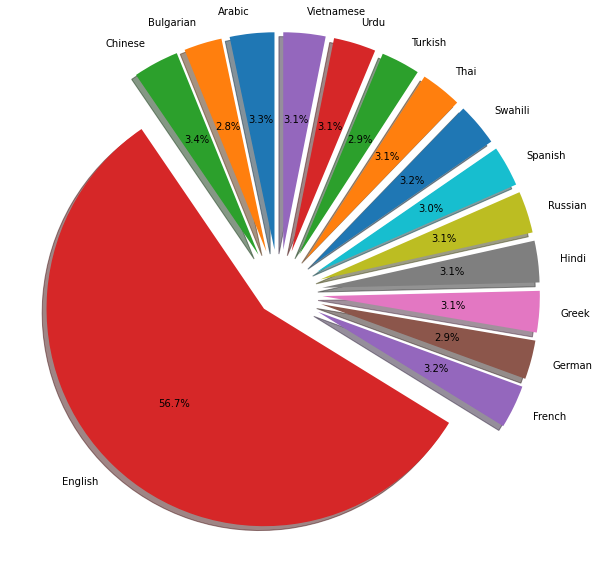

In [28]:
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%', shadow=True, startangle=90, explode = explode)
plt.show()

## Encoding data

In [17]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [18]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [20]:
tokenized_dict = tokenizer.encode_plus(
    "Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.",
    add_special_tokens=True,
    max_length=5
    )
tokenized_dict

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': [101, 13810, 32181, 65533, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [26]:
" ".split("Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.")

['D']

In [22]:
encode_sentence("Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.")

[13810,
 32181,
 65533,
 10986,
 29069,
 118,
 10331,
 18903,
 10231,
 59583,
 14238,
 54576,
 10260,
 10794,
 10121,
 178,
 112,
 62382,
 10112,
 10104,
 14131,
 119,
 102]

In [57]:
def bert_encoder(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [58]:
train_input = bert_encoder(train.premise.values, train.hypothesis.values, tokenizer)

In [56]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10111, 11762, ...,     0,     0,     0],
        [  101, 13252, 10301, ...,     0,     0,     0],
        [  101, 13810, 32181, ...,     0,     0,     0],
        ...,
        [  101, 10117, 12452, ...,     0,     0,     0],
        [  101, 11699, 10105, ...,     0,     0,     0],
        [  101, 11399, 14764, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [33]:
max_len = 50

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [35]:
with strategy.scope():
    model = build_model()
    model.summary()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 64, validation_split = 0.2)

In [71]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

FileNotFoundError: [Errno 2] File b'../input/contradictory-my-dear-watson/test.csv' does not exist: b'../input/contradictory-my-dear-watson/test.csv'